[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/neverorfrog/whistlenet/blob/main/main_colab.ipynb)

In [1]:
import sys

COLAB_RUNTIME = 'google.colab' in sys.modules
if COLAB_RUNTIME:
    !git init
    !git remote add origin https://github.com/neverorfrog/whistlenet.git
    !git pull origin main
    !pip install -q -r requirements.txt
else:
    !pip install -q -r requirements.txt
    !pre-commit autoupdate
    !pre-commit install

[https://github.com/psf/black] already up to date!
[https://github.com/pycqa/isort] already up to date!
pre-commit installed at .git/hooks/pre-commit


In [2]:
from config import *
import os
import warnings
warnings.filterwarnings("ignore")
import torch
import numpy as np

config_path = os.path.join("config","config.yaml")
config: Config = load_config(config_path)
torch_config: TorchConfig = config.torch
dataset_config: DatasetConfig = config.dataset
trainer_config: TrainerConfig = config.trainer
baseline_config: BaselineConfig = config.baseline
whistlenet_config: WhistlenetConfig = config.whistlenet
torch.manual_seed(torch_config.seed)
np.random.seed(torch_config.seed)

DATA LOADED!

N Examples: 228475
N Classes: 2
Classes: [0. 1.]
 - Class 0: 114244 (50.00284495021338)
 - Class 1: 114231 (49.99715504978663)


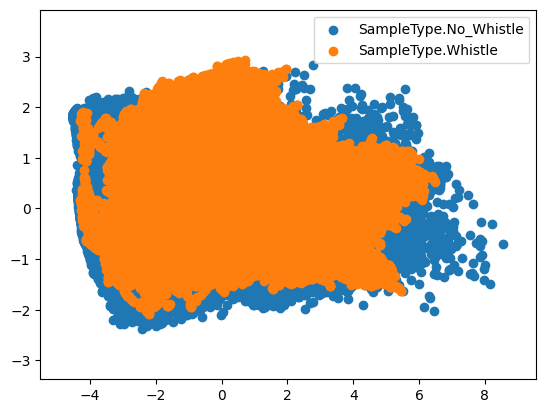

In [3]:
from whistlenet.data import WhistleDataset
from whistlenet.core.utils import plot, NUM_FREQS
from whistlenet.core.utils.audio import SampleType

#import gdown
#download_path = os.path.join(dataset_config.download_folder, dataset_config.name)
#gdown.download_folder(
#    dataset_config.drive_url, output=download_path
#)

dataset = WhistleDataset(dataset_config)
dataset.summarize()
reshaped = dataset.train_data.reshape((dataset.train_data.data.shape[0], NUM_FREQS))
plot(reshaped, dataset.train_data.labels, SampleType)

In [ ]:
from whistlenet.models import WhistleNet, Baseline
from whistlenet.core import LightningTrainer

model = WhistleNet(in_channels=1, out_channels=1, config=whistlenet_config)
trainer = LightningTrainer(trainer_config)
trainer.fit(model,dataset)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name            | Type              | Params | Mode 
---------------------------------------------------------------
0  | train_f1        | BinaryF1Score     | 0      | train
1  | train_precision | BinaryPrecision   | 0      | train
2  | train_recall    | BinaryRecall      | 0      | train
3  | train_accuracy  | BinaryAccuracy    | 0      | train
4  | val_f1          | BinaryF1Score     | 0      | train
5  | val_precision   | BinaryPrecision   | 0      | train
6  | val_recall      | BinaryRecall      | 0      | train
7  | val_accuracy    | BinaryAccuracy    | 0      | train
8  | test_f1         | BinaryF1Score     | 0      | train
9  | test_precision  | BinaryPrecision   | 0      | train
10 | test_recall     | BinaryRecall      | 0      | train
11 | test_accuracy   | BinaryAccuracy    | 0      | train
12 | backbone        | Sequential        | 111 K  | train
13 | pool   

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]